# Research Question 3: What are the major differences between the 2017 and 2023 datasets? What determines longevity/resilience of rankings?
## Importing libraries

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import shapiro, anderson, jarque_bera, spearmanr, probplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve

## Loading/constructing Dataframes

In [3]:
df_17 = pd.read_csv(f'data/2017/basic_data_2017.csv', index_col='Unnamed: 0', encoding='utf-8') 
df_23 = pd.read_csv(f'data/2023/basic_data_2023.csv', index_col='Unnamed: 0', encoding='utf-8')

In [8]:
df_merged = pd.merge(df_17, df_23, on='game_id', suffixes=('_17', '_23'))
df_sorted = df_merged.sort_values('game_id')
df = df_sorted[['game_id', 'rank_17', 'rank_23', 'num_votes_17', 'num_votes_23']].copy()
df.loc[:,'rank_change'] = df['rank_17'] - df['rank_23']
df.loc[:,'vote_change'] =  df['num_votes_23'] - df['num_votes_17']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1219 entries, 147 to 1214
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   game_id       1219 non-null   int64
 1   rank_17       1219 non-null   int64
 2   rank_23       1219 non-null   int64
 3   num_votes_17  1219 non-null   int64
 4   num_votes_23  1219 non-null   int64
 5   rank_change   1219 non-null   int64
 6   vote_change   1219 non-null   int64
dtypes: int64(7)
memory usage: 76.2 KB


## EDA

<Axes: xlabel='rank_change', ylabel='Count'>

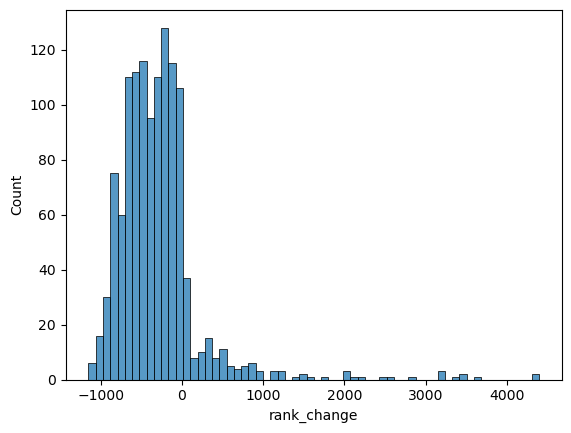

In [10]:
plt.title('Change in rank')
sns.histplot(data=df, x='rank_change')

In [31]:
# Anderson-Darling
result = anderson(df['rank_change'])
print('stat=%.3f' % result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Data follows Normal at the %.1f%% level' % (sl))
    else:
        print('Data does not follow normal at the %.1f%% level' % (sl))

stat=58.986
Data does not follow normal at the 15.0% level
Data does not follow normal at the 10.0% level
Data does not follow normal at the 5.0% level
Data does not follow normal at the 2.5% level
Data does not follow normal at the 1.0% level


In [27]:
mask_17 = df_17[['game_id',
                 'geek_rating',
                 'min_players',
                 'max_players',
                 'avg_time',
                 'min_time',
                 'max_time',
                 'num_votes',
                 'weight']]
mask_17 = mask_17.merge(df, on='game_id')
mask_17['avg_players'] = (mask_17['max_players'] + mask_17['min_players'])/2

In [28]:
for col in mask_17:
    rho, p = spearmanr(mask_17['rank_change'], mask_17[col])
    print(f'{col} correlation with rank_change', 'rho=%.3f, p=%.3f' % (rho,p))

game_id correlation with rank_change rho=0.373, p=0.000
geek_rating correlation with rank_change rho=0.736, p=0.000
min_players correlation with rank_change rho=-0.137, p=0.000
max_players correlation with rank_change rho=0.038, p=0.190
avg_time correlation with rank_change rho=0.069, p=0.015
min_time correlation with rank_change rho=-0.060, p=0.038
max_time correlation with rank_change rho=0.069, p=0.015
num_votes correlation with rank_change rho=0.533, p=0.000
weight correlation with rank_change rho=0.074, p=0.009
rank_17 correlation with rank_change rho=-0.330, p=0.000
rank_23 correlation with rank_change rho=-0.736, p=0.000
num_votes_17 correlation with rank_change rho=0.121, p=0.000
num_votes_23 correlation with rank_change rho=0.533, p=0.000
rank_change correlation with rank_change rho=1.000, p=0.000
vote_change correlation with rank_change rho=0.745, p=0.000
avg_players correlation with rank_change rho=-0.012, p=0.681


In [30]:
features = mask_17[['avg_time',
                   'min_players',
                   'num_votes',
                   'weight']]
target = np.cbrt(mask_17['rank_change'])
X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred = model.predict(sm.add_constant(X_test))
print(model.summary())

#Check for Variance Inflation Factor (VIF) for Multicoolinearity Issues

x_temp = sm.add_constant(X_train)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
print(vif.round(1))

percent_effect = (np.exp(model.params) - 1) * 100
print(percent_effect)

                            OLS Regression Results                            
Dep. Variable:            rank_change   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     9.204
Date:                Thu, 27 Jul 2023   Prob (F-statistic):           2.72e-07
Time:                        13:50:53   Log-Likelihood:                -2772.3
No. Observations:                 914   AIC:                             5555.
Df Residuals:                     909   BIC:                             5579.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.6171      0.813     -6.907      